# Imports

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:       394354152 kB
MemFree:        162324424 kB
MemAvailable:   377640456 kB


In [2]:
import multiprocessing
multiprocessing.cpu_count()

64

In [3]:
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sns
import sys
import os
import pickle
import dill
import warnings
import json
from tqdm import tqdm
from collections import defaultdict

In [4]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.base import ClassifierMixin, BaseEstimator

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [6]:
from IPython.display import clear_output

In [7]:
main_dir = '/sise/home/tommarz/hate_speech_detection/'
detection_dir = os.path.join(main_dir, 'detection')
experiments_dir = os.path.join(detection_dir, 'experiments')
aggregative_methods_dir = os.path.join(detection_dir, 'aggregative_methods')
models_dir = os.path.join(aggregative_methods_dir, 'models')
node2vec_dir =  os.path.join(detection_dir, 'node2vec')
sna_dir = os.path.join(detection_dir, 'sna')
os.chdir(main_dir)
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

In [8]:
from config.data_config import path_confs
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

In [9]:
def write_results_latex(df, name):
    with open(os.path.join(method_output_path, f'{method_name}_{name}_results_latex.txt'), 'w') as f:
        res = ' & '.join([f'${m:.3f} \pm {s:.3f}$' for m, s in df.values.reshape(-1, 2)]) + '\\\\'
        f.write(res)

def get_best_results_from_gs(gs):
    train_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[
                                     gs.best_index_, [c for c in gs.cv_results_ if
                                                      'mean_train' in c or 'std_train' in c]].values.reshape(-1, 2),
                                 columns=['mean', 'std'], index=scoring_names)
    test_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if
                                                                                            'mean_test' in c or 'std_test' in c]].values.reshape(
        -1, 2), columns=['mean', 'std'], index=scoring_names)
    # best_hyper_params = pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    return {'train': train_results, 'test': test_results}

def get_best_results_from_cv_results(cv_results):
    train_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_train' in c or 'std_train' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    test_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_test' in c or 'std_test' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    return {'train': train_results, 'test': test_results}

def write_best_results_and_params_from_gs(gs):
    results_dict = get_best_results_from_gs(gs)
    pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    pd.Series(gs.best_estimator_.get_learned_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_params.csv'))

    for name, df in results_dict.items():
        write_results_latex(df, name=name)
        df.to_csv(os.path.join(method_output_path, f'best_results_{name}.csv'))
        
    return results_dict

In [10]:
def get_all_predictions(model, grid_search, kf, X, y):
    
    all_predictions = []
    
    grid_search.fit(X, y)

    # Loop through folds explicitly
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Train and test split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Get the model trained during this fold (best params are already chosen)
        best_params = grid_search.best_params_
        fold_model = model.set_params(**best_params)
        fold_model.fit(X_train, y_train)

        # Predict on the test set
        predictions = fold_model.predict(X_test)
        probas = fold_model.predict_proba(X_test)

        # Store the predictions and true labels in a DataFrame
        fold_predictions = pd.DataFrame({
            'fold': fold_idx,
            'index': test_index,
            'true_label': y_test,
            'predicted_label': predictions,
            'probas': probas[:, 1]
        }, index=X_test.index)
        all_predictions.append(fold_predictions)

    # Concatenate all fold predictions into a single DataFrame
    final_predictions = pd.concat(all_predictions, ignore_index=False).loc[y.index]

    return final_predictions

In [11]:
scoring_list = [precision_score, recall_score, f1_score, roc_auc_score]
scoring_names = ['_'.join(f.__name__.split('_')[:-1]) for f in scoring_list]
scoring_dict = {n:f for n, f in zip(scoring_names, scoring_list)}
scoring_dict

{'precision': <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'recall': <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'f1': <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'roc_auc': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

# Choose Dataset

In [12]:
dataset = 'parler'

In [13]:
dataset_path_conf = path_confs[dataset]
network_output_dir = "/sise/home/tommarz/hate_speech_detection/data/networks_data"
raw_graphs_dict_path = os.path.join(network_output_dir, "raw_graphs_dict.p")
network_dataset_output_dir = os.path.join(network_output_dir, dataset)
raw_network_path  = os.path.join(network_dataset_output_dir, "raw_network.p")
raw_network_edgelist_path  = os.path.join(network_dataset_output_dir, "raw_network.txt")
largest_cc_path  = os.path.join(network_dataset_output_dir, "largest_cc.p")
largest_cc_edgelist_path  = os.path.join(network_dataset_output_dir, "largest_cc.txt")


# Load Dataset (Graph)

In [14]:
largest_cc_path

'/sise/home/tommarz/hate_speech_detection/data/networks_data/gab/largest_cc.p'

In [15]:
with open(largest_cc_path, 'rb') as f:
    g = pickle.load(f)
# g.reverse_edges()
g.summary()

'IGRAPH DNW- 51195 2472710 -- gab\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [16]:
labeled_nodes = g.vs.select(lambda v: v['label'] != -1)
len(labeled_nodes)

982

In [17]:
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label')
y

1843      0
160776    0
3622      0
4735      0
180913    1
         ..
184621    0
358098    1
381309    1
66360     0
112868    0
Name: label, Length: 982, dtype: int64

In [18]:
(np.array(g.vs.degree())==0).sum()

0

In [19]:
def expect_precision(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    # idxs = np.where(y_prob < thres)[0]
    # fn = y_prob[idxs].sum()
    return tp/(tp+fp)

def expect_f1(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_true, y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_true, y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres #, f1s 

# Load Posts and Predictions

In [20]:
dataset_path_conf['posts_with_predictions']

'/sise/home/tommarz/hate_speech_detection/detection/outputs/gab/BertFineTuning/user_level/split_by_posts/with_text/'

In [21]:
posts_with_predictions_df = pd.read_parquet(dataset_path_conf['posts_with_predictions'])

In [22]:
predictions_output_path = os.path.join(post_level_execution_config["evaluation"]["output_path"], 'predictions.tsv')
predictions_df = pd.read_csv(predictions_output_path, sep='\t')
y_true = predictions_df['y_true']
y_prob = predictions_df['y_score']
y_pred = predictions_df['y_pred']

In [23]:
# def optimal_threshold(y_true, y_prob):
y_prob = np.sort(y_prob)[::-1]
precisions = [expect_precision(y_true, y_prob, p) for p in y_prob]
thres = y_prob[np.argmax(precisions)]
thres

0.9950218

In [24]:
post_threshold = optimal_threshold(y_true, y_prob)
# post_threshold=0.9
# post_threshold=thres
post_threshold

0.4196834

# Define Ego Network

In [25]:
def get_ego_subgraph(g, vertices, order_k = 1):
    ego_network = g.neighborhood(vertices=vertices, order=order_k, mode='out')
    set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
    flattened_set = list({element for tupl in set_of_tuples for element in tupl})
    ego_subgraph = g.subgraph(flattened_set)
    return ego_subgraph

In [26]:
ego_g = get_ego_subgraph(g, labeled_nodes, order_k=1)
ego_g.summary()

'IGRAPH DNW- 12959 1722601 -- gab\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [27]:
labeled_nodes_ego = ego_g.vs.select(lambda v: v['label']!=-1)
v = labeled_nodes_ego[0]

# Define Seed (Random State)

In [28]:
seed = 42

In [29]:
results_str = ''

# Define Centrality Measures

# Define Post Threshold for HS Count

In [30]:
post_th = 0.5 #np.percentile(preds, q=99)

In [31]:
def get_hs_count(hate_probas, post_threshold):
    return (hate_probas >= post_threshold).sum()

# Aggregative Methods

In [32]:
methods = ['fixed_threshold', 'relational_aggregation', 'distributional_bins', 'distributional_quantiles', 'distributional_bins_quantiles', 'multimodal_relational_bins_quantiles']

In [33]:
results_dict = defaultdict(dict)
preds_dict = defaultdict(dict)
data_dict = defaultdict(dict)
models_dict = defaultdict(dict)

In [34]:
kf = StratifiedKFold(shuffle=True, random_state=seed)

In [35]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions') #.sort_index()
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label') #.sort_index()

## Fixed Threshold

In [36]:
method_name = methods[0]
method_name

'fixed_threshold'

In [37]:
y.mean()

0.2494908350305499

In [38]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [39]:
hs_count_transformer = FunctionTransformer(lambda X, post_threshold=0.5: np.array([get_hs_count(np.array(prob_list), post_threshold) for prob_list in X]).reshape(-1, 1), validate=False)

In [40]:
all_probas_concat = np.concatenate(labeled_nodes['predictions'])

In [41]:
mean_probas = np.array(list(map(np.mean, labeled_nodes['predictions'])))
post_thresholds = np.percentile(mean_probas, q=[1,5,10,25,50,75,90,95,99])

In [42]:
post_thresholds = np.sort(np.concatenate((np.quantile(all_probas_concat, np.linspace(0, 1, 11)), [0.5])))
post_thresholds

array([0.02101032, 0.03461504, 0.04148857, 0.04832265, 0.05809789,
       0.0732365 , 0.10172405, 0.1709324 , 0.32012063, 0.5       ,
       0.7046138 , 0.98963928])

### Without ML

In [43]:
class FixedThresholdClassifer(ClassifierMixin, BaseEstimator):
    def __init__(self, post_th):
        self.post_th = post_th
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def predict(self, X):
        return (X>=self.post_th).astype(int)
    def predict_proba(self, X):
        preds = self.predict(X)
        return np.column_stack((1-preds, preds))
    def decision_function(self, X):
        return self.predict(X)

In [44]:
hs_count = hs_count_transformer.fit_transform(X)
# hs_count

In [45]:
scores_dict = {post_th: {k: v(y, hs_count >= post_th) for k,v in scoring_dict.items()} for post_th in [1,3,10,50,100]}
scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df.T

,precision,recall,f1,roc_auc
1,0.251799,1.000000,0.402299,0.506106
3,0.256813,1.000000,0.408674,0.518996
10,0.280886,0.983673,0.436990,0.573248
50,0.379501,0.559184,0.452145,0.627624
100,0.436548,0.351020,0.389140,0.600205


### With ML (LR)

#### Train

In [46]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    hs_count_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7fb97c148820>)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [47]:
param_grid = {
    # 'functiontransformer__kw_args': [{'post_threshold': p} for p in post_thresholds],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [48]:
fixed_gs = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [49]:
all_preds_fixed = get_all_predictions(pipe, fixed_gs, kf, X, y)
all_preds_fixed

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,1,0.511928
160776,0,1,0,1,0.614112
3622,3,2,0,0,0.466160
4735,1,3,0,1,0.725404
180913,4,4,1,0,0.459897
...,...,...,...,...,...
184621,1,977,0,0,0.418376
358098,3,978,1,0,0.438952
381309,0,979,1,0,0.436484
66360,2,980,0,0,0.422760


In [50]:
method_name

'fixed_threshold'

In [51]:
all_preds_fixed.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

#### Results

In [52]:
results_dict_fixed = get_best_results_from_gs(fixed_gs)
for name, df in results_dict_fixed.items():
    print(name)
    display(df.round(3))

train


,mean,std
precision,0.467286,0.024904
recall,0.328571,0.013147
f1,0.385701,0.016138
roc_auc,0.702673,0.009192


test


,mean,std
precision,0.465975,0.072044
recall,0.334694,0.06136
f1,0.387712,0.061019
roc_auc,0.701768,0.036622


In [53]:
results_dict['fixed'] = results_dict_fixed['test']

In [54]:
fixed_overleaf = '& Fixed-Threshold '
for m, s in results_dict_fixed['test'].astype(float).values:
    fixed_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(fixed_overleaf + '\\\\')

& Fixed-Threshold & $0.466 \pm 0.072$& $0.335 \pm 0.061$& $0.388 \pm 0.061$& $0.702 \pm 0.037$\\


In [55]:
best_pipe = fixed_gs.best_estimator_
best_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7fb97c148820>)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [56]:
models_dict[dataset][method_name] = best_pipe

In [57]:
with open(os.path.join(models_dir, dataset, f'{method_name}.dill'), 'wb') as f:
    dill.dump(best_pipe, f)

In [58]:
fixed_model = best_pipe.steps[-1][1]
fixed_model

LogisticRegression(class_weight='balanced', random_state=42)

## Relational Aggregation

In [59]:
method_name = methods[1]
method_name

'relational_aggregation'

In [60]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions') #.sort_index()
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label') #.sort_index()

In [61]:
# agg_func = np.mean
def get_relational_feats(g, vs=None, pipe=None, agg_func=np.mean, weighted=False):
    if vs is None:
        vs = g.vs.select(lambda v: v['label'] != -1)
    res = []
    for v in vs:
        self_preds = v['predictions']
        followers = g.vs[g.neighbors(v, mode='in')]
        followees = g.vs[g.neighbors(v, mode='out')]
        followers_preds = np.array(followers['predictions'], dtype='O')
        followees_preds = np.array(followees['predictions'], dtype='O')

        self_agg = agg_func(self_preds)
        followers_agg = np.array([agg_func(p) for p in followers_preds])
        followees_agg = np.array([agg_func(p) for p in followees_preds])

        followers_weights = np.array(g.es.select(_target=v.index)['weight']) if weighted else np.ones_like(g.es.select(_target=v.index), dtype=int)
        followees_weights = np.array(g.es.select(_source=v.index)['weight']) if weighted else np.ones_like(g.es.select(_source=v.index), dtype=int)

        followers_agg_weighted = (followers_agg * followers_weights).sum()/followers_weights.sum() if len(followers)>0 else 0
        followees_agg_weighted = (followees_agg * followees_weights).sum()/followees_weights.sum() if len(followees)>0 else 0

        # mean_followers_agg_weighted = followers_agg_weighted.mean() if followers_agg_weighted.size>0 else 0
        # mean_followees_agg_weighted = followees_agg_weighted.mean() if followees_agg_weighted.size>0 else 0
        res.append([self_agg, followers_agg_weighted, followees_agg_weighted])
    df = pd.DataFrame(res, columns=['self', 'followers_agg', 'followees_agg'], index=vs['name'])
    return df

In [146]:
weighted = True
agg_func = lambda p, th=0.5: get_hs_count(p, th)
relational_transformer = FunctionTransformer(get_relational_feats, kw_args={'vs': labeled_nodes, 'agg_func': agg_func, 'weighted': weighted, 'vs':g.vs})

In [147]:
X_all = relational_transformer.fit_transform(g)
X_all

,self,followers_agg,followees_agg
1175,505,2467.094194,1086.064272
7475,411,2541.168509,1236.800279
4555,5471,2888.387609,1672.838871
122066,293,2427.711207,1360.726210
7334,163,2459.660173,1249.323077
...,...,...,...
126275,2,0.000000,199.000000
335103,0,0.000000,109.333333
348173,3,0.000000,238.500000
38500,0,0.000000,5.000000


### Train

In [148]:
X = X_all.loc[y.index]
X

,self,followers_agg,followees_agg
1843,125,1982.883495,2011.250000
160776,284,2806.080537,1255.693333
3622,63,1850.955224,856.992806
4735,407,2566.778157,1275.958333
180913,42,3302.040000,2178.750000
...,...,...,...
184621,13,0.000000,442.119565
358098,19,76.000000,302.460526
381309,17,52.000000,633.936709
66360,22,0.000000,387.821705


In [149]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [150]:
pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=seed))
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(random_state=seed))
# pipe = make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression(random_state=seed))
pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('logisticregression', LogisticRegression(random_state=42))])

In [151]:
param_grid = {
    # 'functiontransformer__kw_args': [{'agg_func': lambda p, th: get_hs_count(p, th), 'weighted': weighted} for th, weighted in np.column_stack((thresholds.flatten(), is_weighted.flatten()))],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [152]:
gs_relational = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [153]:
all_preds_df = get_all_predictions(pipe, gs_relational, kf, X, y)
all_preds_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,1,0.544506
160776,0,1,0,1,0.610534
3622,3,2,0,0,0.454010
4735,1,3,0,1,0.707860
180913,4,4,1,1,0.521572
...,...,...,...,...,...
184621,1,977,0,0,0.361685
358098,3,978,1,0,0.401297
381309,0,979,1,0,0.392509
66360,2,980,0,0,0.364092


In [154]:
all_preds_df.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

### Results

In [155]:
results_dict_relat = get_best_results_from_gs(gs_relational)
for name, df in results_dict_relat.items():
    print(name)
    display(df)

train


,mean,std
precision,0.422463,0.028794
recall,0.417347,0.015609
f1,0.41939,0.018108
roc_auc,0.679396,0.008807


test


,mean,std
precision,0.407967,0.066846
recall,0.428571,0.093966
f1,0.414462,0.06893
roc_auc,0.675371,0.044668


In [156]:
results_dict['relational'] = results_dict_relat['test']

In [157]:
overleaf = '& Relational Aggregation '
for m, s in results_dict_relat['test'].astype(float).values:
    overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(overleaf + '\\\\')

& Relational Aggregation & $0.408 \pm 0.067$& $0.429 \pm 0.094$& $0.414 \pm 0.069$& $0.675 \pm 0.045$\\


In [74]:
best_pipe = gs_relational.best_estimator_
model = best_pipe.steps[-1][1]
best_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    random_state=42))])

In [75]:
models_dict[method_name] = best_pipe

In [76]:
with open(os.path.join(models_dir, dataset, f'{method_name}.dill'), 'wb') as f:
    dill.dump(best_pipe, f)

## Distributional (Bins)

In [77]:
method_name = methods[2]
method_name

'distributional_bins'

### Train

In [78]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions') #.sort_index()
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label') #.sort_index()

In [79]:
assert((X.index == y.index).all())

In [80]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [81]:
n_bins = 10
density = True
bins_range = (0, 1)
hs_bins_count_transformer = FunctionTransformer(
    lambda X, n_bins, bins_range=(0,1), density=True: pd.DataFrame(np.array([np.histogram(prob_list, bins=n_bins, range=bins_range, density=density)[0] for prob_list in X])/n_bins,
                                                                   columns=[f'percent_of_hs_posts_bin_{idx+1}' for idx in range(n_bins)], index=X.index), validate=False, kw_args={'n_bins' :n_bins, 'density': density, 'bins_range': bins_range}, feature_names_out=lambda self, input_features: [f'percent_of_hs_posts_bin_{idx+1}' for idx in range(self.kw_args['n_bins'])])

In [82]:
hs_bins_count_transformer.fit_transform(X)

,percent_of_hs_posts_bin_1,percent_of_hs_posts_bin_2,percent_of_hs_posts_bin_3,percent_of_hs_posts_bin_4,percent_of_hs_posts_bin_5,percent_of_hs_posts_bin_6,percent_of_hs_posts_bin_7,percent_of_hs_posts_bin_8,percent_of_hs_posts_bin_9,percent_of_hs_posts_bin_10
1843,0.778370,0.109292,0.036558,0.019421,0.008759,0.012947,0.010663,0.008759,0.009901,0.005331
160776,0.636680,0.102147,0.045850,0.027858,0.022635,0.027858,0.031341,0.028439,0.029019,0.048172
3622,0.727979,0.116580,0.031088,0.024611,0.018135,0.018135,0.019430,0.020725,0.014249,0.009067
4735,0.605231,0.149846,0.059385,0.032615,0.027692,0.029231,0.021846,0.028308,0.025538,0.020308
180913,0.646302,0.125402,0.035370,0.035370,0.022508,0.006431,0.038585,0.025723,0.032154,0.032154
...,...,...,...,...,...,...,...,...,...,...
184621,0.651376,0.165138,0.018349,0.027523,0.018349,0.009174,0.009174,0.027523,0.009174,0.064220
358098,0.648649,0.090090,0.036036,0.036036,0.018018,0.036036,0.036036,0.027027,0.054054,0.018018
381309,0.516667,0.133333,0.066667,0.075000,0.066667,0.016667,0.025000,0.025000,0.033333,0.041667
66360,0.691667,0.033333,0.033333,0.041667,0.016667,0.025000,0.041667,0.025000,0.025000,0.066667


In [83]:
(hs_bins_count_transformer.fit_transform(X).sum(axis=1)-1 < 1e-10).all()

True

In [84]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    hs_bins_count_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb93fd5f160>,
                                     func=<function <lambda> at 0x7fb93fd5f0d0>,
                                     kw_args={'bins_range': (0, 1),
                                              'density': True, 'n_bins': 10})),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [85]:
n_bins = 10
density = True
bins_range = (0, 1)
param_grid = {
    'functiontransformer__kw_args': [{'n_bins': n_bins, 'density': density, 'bins_range': bins_range}],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [86]:
bins_gs = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [87]:
all_preds_df = get_all_predictions(pipe, bins_gs, kf, X, y)
all_preds_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,0,0.235208
160776,0,1,0,0,0.489846
3622,3,2,0,0,0.289178
4735,1,3,0,0,0.406783
180913,4,4,1,0,0.466893
...,...,...,...,...,...
184621,1,977,0,0,0.427606
358098,3,978,1,1,0.513134
381309,0,979,1,0,0.488169
66360,2,980,0,1,0.500363


In [88]:
all_preds_df.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

### Results

In [89]:
results_dict_bins = get_best_results_from_gs(bins_gs)
for name, df in results_dict_bins.items():
    print(name)
    display(df)

train


,mean,std
precision,0.449905,0.012756
recall,0.643878,0.007498
f1,0.529509,0.007257
roc_auc,0.774369,0.003041


test


,mean,std
precision,0.461097,0.034025
recall,0.64898,0.04358
f1,0.537511,0.023652
roc_auc,0.763339,0.01562


In [90]:
bins_overleaf = '& Distributional (Bins) '
for m, s in results_dict_bins['test'].astype(float).values:
    bins_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(bins_overleaf + '\\\\')

& Distributional (Bins) & $0.461 \pm 0.034$& $0.649 \pm 0.044$& $0.538 \pm 0.024$& $0.763 \pm 0.016$\\


In [91]:
results_dict['disributional_bins'] = results_dict_bins['test']

In [92]:
best_pipe = bins_gs.best_estimator_
best_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb93fd5f160>,
                                     func=<function <lambda> at 0x7fb93fd5f0d0>,
                                     kw_args={'bins_range': (0, 1),
                                              'density': True, 'n_bins': 10})),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.021544346900318846,
                                    class_weight='balanced',
                                    random_state=42))])

In [93]:
models_dict[method_name] = best_pipe

In [94]:
bins_model = best_pipe.steps[-1][1]
bins_model

LogisticRegression(C=0.021544346900318846, class_weight='balanced',
                   random_state=42)

In [95]:
bins_model.coef_[0]

array([-0.22779745, -0.050513  , -0.03496818, -0.01348526,  0.0984831 ,
       -0.01525589,  0.02833123,  0.08142869,  0.35333928,  0.50039676])

In [96]:
bins_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
bins_preds_df

,pred,label
1843,0,0
160776,0,0
3622,0,0
4735,0,0
180913,0,1
...,...,...
184621,0,0
358098,0,1
381309,1,1
66360,0,0


## Distributional (Qunatiles)

In [97]:
method_name = methods[3]
method_name

'distributional_quantiles'

### Train

In [98]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [99]:
# Sample data: a list of NumPy arrays with probabilities
k = 10
probability_arrays = X  # Replace with your actual data
q = np.linspace(0, 1, k+1)
# Define a function to calculate quantiles
def calculate_quantiles(data, q):
    return np.quantile(data, q)

# Define a function to calculate the mean probability in each quantile
def mean_probabilities_in_quantiles(data, q):
    quantiles = calculate_quantiles(data, q)
    # print(quantiles)
    mean_probs = []
    for i in range(len(quantiles) - 1):
        quantile_range = data[(data >= quantiles[i]) & (data < quantiles[i + 1])]
        mean_probs.append(np.mean(quantile_range) if len(quantile_range) > 0 else 0)
    return np.array(mean_probs)

# Vectorize the mean probabilities function
vectorized_mean_probs = np.vectorize(mean_probabilities_in_quantiles, signature='(n)->(m)')

# Use FunctionTransformer to apply the vectorized function
mean_quantile_hs_proba_transformer = FunctionTransformer(lambda x, q: np.array([mean_probabilities_in_quantiles(arr, q) for arr in x]), kw_args={'q': q},
                                                         feature_names_out=lambda self, input_features: [f'quantile_{idx+1}_mean_proba' for idx, e in enumerate(self.kw_args['q'][1:])])

In [100]:
mean_quantile_hs_proba_transformer.kw_args['q']

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [101]:
# Transform the list of probability arrays into a single NumPy array
quantile_means_array = mean_quantile_hs_proba_transformer.fit_transform(probability_arrays)

# Print the result
print("Mean probabilities in each quantile for all arrays:")
pd.DataFrame(quantile_means_array, columns=mean_quantile_hs_proba_transformer.get_feature_names_out())

Mean probabilities in each quantile for all arrays:


,quantile_1_mean_proba,quantile_2_mean_proba,quantile_3_mean_proba,quantile_4_mean_proba,quantile_5_mean_proba,quantile_6_mean_proba,quantile_7_mean_proba,quantile_8_mean_proba,quantile_9_mean_proba,quantile_10_mean_proba
0,0.030829,0.036966,0.041584,0.046242,0.051878,0.059033,0.070507,0.091123,0.153855,0.508288
1,0.028468,0.033456,0.038235,0.045063,0.053836,0.070590,0.110219,0.228927,0.545715,0.875261
2,0.027287,0.031925,0.036205,0.041913,0.049769,0.059925,0.077902,0.111312,0.233000,0.665328
3,0.029162,0.036735,0.043962,0.052876,0.065707,0.084572,0.118680,0.200927,0.415510,0.784387
4,0.027584,0.032380,0.037346,0.041972,0.048406,0.062477,0.100366,0.178970,0.448307,0.840237
...,...,...,...,...,...,...,...,...,...,...
977,0.027216,0.032225,0.038522,0.046330,0.055434,0.066305,0.100697,0.149697,0.361789,0.855911
978,0.028845,0.036143,0.042500,0.047734,0.060214,0.073125,0.126830,0.223298,0.512437,0.813063
979,0.030903,0.041027,0.049856,0.058617,0.079090,0.117806,0.193312,0.327451,0.512182,0.859821
980,0.032616,0.038013,0.040467,0.042529,0.044991,0.050091,0.069315,0.253967,0.604121,0.913958


In [102]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    mean_quantile_hs_proba_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                                     func=<function <lambda> at 0x7fb97c3bb670>,
                                     kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [103]:
q = np.linspace(0, 1, 11)

param_grid = {
    'functiontransformer__kw_args': [{'q': q}],
    'logisticregression__C': np.logspace(0, -5, 30),
    'logisticregression__class_weight': ['balanced']
}

In [104]:
quantiles_gs = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [105]:
all_preds_df = get_all_predictions(pipe, quantiles_gs, kf, X, y)
all_preds_df

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,0,0.203747
160776,0,1,0,1,0.519956
3622,3,2,0,0,0.285107
4735,1,3,0,0,0.444814
180913,4,4,1,0,0.468855
...,...,...,...,...,...
184621,1,977,0,0,0.453837
358098,3,978,1,0,0.485629
381309,0,979,1,1,0.550215
66360,2,980,0,1,0.557257


In [106]:
all_preds_df.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

### Results

In [107]:
results_dict_quantiles = get_best_results_from_gs(quantiles_gs)
for name, df in results_dict_quantiles.items():
    print(name)
    display(df)

train


,mean,std
precision,0.428952,0.008719
recall,0.70102,0.01233
f1,0.53218,0.008849
roc_auc,0.773084,0.003595


test


,mean,std
precision,0.429195,0.026615
recall,0.702041,0.055666
f1,0.532236,0.032717
roc_auc,0.769663,0.017904


In [108]:
results_dict['disributional_quantiles'] = results_dict_quantiles['test']

In [109]:
quantiles_overleaf = '& Distributional (Quantiles) '
for m, s in results_dict_quantiles['test'].astype(float).values:
    quantiles_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(quantiles_overleaf + '\\\\')

& Distributional (Quantiles) & $0.429 \pm 0.027$& $0.702 \pm 0.056$& $0.532 \pm 0.033$& $0.770 \pm 0.018$\\


In [110]:
best_pipe = quantiles_gs.best_estimator_
best_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                                     func=<function <lambda> at 0x7fb97c3bb670>,
                                     kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01268961003167922,
                                    class_weight='balanced',
                                    random_state=42))])

In [111]:
models_dict[method_name] = best_pipe

In [112]:
quantiles_model = best_pipe.steps[-1][1]
quantiles_model

LogisticRegression(C=0.01268961003167922, class_weight='balanced',
                   random_state=42)

In [113]:
quantiles_model.coef_[0]

array([-0.01283873, -0.01002153, -0.00548879,  0.01562378,  0.02711872,
        0.04331046,  0.07209401,  0.18020697,  0.31895789,  0.45576085])

In [114]:
quantiles_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
quantiles_preds_df

,pred,label
1843,0,0
160776,1,0
3622,0,0
4735,0,0
180913,0,1
...,...,...
184621,0,0
358098,0,1
381309,1,1
66360,1,0


## Distributional (Bins + Quantiles)

In [115]:
method_name = methods[4]
method_name

'distributional_bins_quantiles'

### Train

In [116]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    make_column_transformer((mean_quantile_hs_proba_transformer, 0), (hs_bins_count_transformer, 0), sparse_threshold=0),
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                                                                      func=<function <lambda> at 0x7fb97c3bb670>,
                                                                      kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}),
                                                  0),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb93fd5f160>,
                                                                      func=<function <lambda> at 0x7fb93fd5f0d0>,
                                                                      kw_args={'bins_range': (0,
                                                                                              1),
                                                                               'density': True,
                                                                               'n_bins': 10}),
                                                  0)])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [117]:
X = pd.DataFrame(np.array(labeled_nodes['predictions']),  index=labeled_nodes['name'], columns=['post_predictions'])
# X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions')
X

/tmp/ipykernel_961073/2502252860.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = pd.DataFrame(np.array(labeled_nodes['predictions']),  index=labeled_nodes['name'], columns=['post_predictions'])


,post_predictions
1843,"[0.03404027596116066, 0.038772229105234146, 0...."
160776,"[0.08092188090085983, 0.10326234996318817, 0.0..."
3622,"[0.1198379397392273, 0.03466568887233734, 0.08..."
4735,"[0.03908070921897888, 0.03266044706106186, 0.0..."
180913,"[0.12725232541561127, 0.10190580040216446, 0.0..."
...,...
184621,"[0.03777375817298889, 0.02822786010801792, 0.0..."
358098,"[0.8092441558837891, 0.03714274242520332, 0.06..."
381309,"[0.04143805429339409, 0.04446610435843468, 0.8..."
66360,"[0.041579604148864746, 0.7251869440078735, 0.0..."


In [118]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [119]:
n_bins = 10
density = True
bins_range = (0, 1)

q = np.linspace(0, 1, 11)

param_grid = {
    'columntransformer__functiontransformer-1__kw_args': [{'q': q}],
    'columntransformer__functiontransformer-2__kw_args': [{'n_bins': n_bins, 'density': density, 'bins_range': bins_range}],
    'logisticregression__C': np.logspace(0, -5, 30),
    'logisticregression__class_weight': ['balanced']
}

In [121]:
bins_quantiles_gs = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [122]:
all_preds_df = get_all_predictions(pipe, bins_quantiles_gs, kf, X, y)
all_preds_df

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,0,0.168322
160776,0,1,0,1,0.564699
3622,3,2,0,0,0.257608
4735,1,3,0,0,0.443138
180913,4,4,1,1,0.519266
...,...,...,...,...,...
184621,1,977,0,1,0.548470
358098,3,978,1,1,0.511883
381309,0,979,1,0,0.494965
66360,2,980,0,1,0.609332


In [123]:
all_preds_df.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

### Results

In [124]:
results_dict_bins_quantiles = get_best_results_from_gs(bins_quantiles_gs)
for name, df in results_dict_bins_quantiles.items():
    print(name)
    display(df)

train


,mean,std
precision,0.445009,0.010241
recall,0.723469,0.018649
f1,0.550916,0.009998
roc_auc,0.785838,0.003193


test


,mean,std
precision,0.434975,0.026446
recall,0.714286,0.042809
f1,0.540276,0.029065
roc_auc,0.769176,0.016108


In [125]:
results_dict['disributional_bins_quantiles'] = results_dict_bins_quantiles['test']

In [126]:
quantiles_overleaf = '& Distributional (Bins + Quantiles) '
for m, s in results_dict_bins_quantiles['test'].astype(float).values:
    quantiles_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(quantiles_overleaf + '\\\\')

& Distributional (Bins + Quantiles) & $0.435 \pm 0.026$& $0.714 \pm 0.043$& $0.540 \pm 0.029$& $0.769 \pm 0.016$\\


In [127]:
best_pipe = bins_quantiles_gs.best_estimator_
best_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                                                                      func=<function <lambda> at 0x7fb97c3bb670>,
                                                                      kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}),
                                                  0),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb93fd5f160>,
                                                                      func=<function <lambda> at 0x7fb93fd5f0d0>,
                                                                      kw_args={'bins_range': (0,
                                                                                              1),
                                                                               'density': True,
                                                                               'n_bins': 10}),
                                                  0)])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.028072162039411756,
                                    class_weight='balanced',
                                    random_state=42))])

In [128]:
models_dict[method_name] = best_pipe

In [129]:
bins_quantiles_model = best_pipe.steps[-1][1]
bins_quantiles_model

LogisticRegression(C=0.028072162039411756, class_weight='balanced',
                   random_state=42)

In [130]:
bins_quantiles_model.coef_[0]

array([-0.05458217, -0.03778861, -0.02603707,  0.00545943,  0.00245668,
       -0.01760163, -0.02364537,  0.09523794,  0.26082768,  0.52528162,
       -0.10411822, -0.02265226, -0.02985777, -0.03194774,  0.04414966,
       -0.07169829, -0.06887682, -0.03461594,  0.17959166,  0.3123186 ])

## Multimodal (Relational + Bins + Quantiles)

In [158]:
method_name = methods[5]
method_name

'multimodal_relational_bins_quantiles'

In [159]:
def get_relational_features(g, vs=None, pipe=None, features_attr_name='features', agg_func=np.mean, weighted=False):
    if vs is None:
        vs = g.vs.select(label_ne=-1)
    res = []
    for v in vs:
        self_feats = v[features_attr_name]
        followers = h.vs[g.neighbors(v, mode='in')]
        followees = h.vs[g.neighbors(v, mode='out')]
        followers_feats = np.array(followers[features_attr_name]) if len(followers)>0 else np.zeros_like(self_feats).reshape(-1, 1)
        followees_feats = np.array(followees[features_attr_name]) if len(followees)>0 else np.zeros_like(self_feats).reshape(-1, 1)

        followers_weights = np.array(h.es.select(_target=v.index)['weight']).reshape(-1, 1) if weighted and len(followers)>0 else np.ones_like(h.es.select(_target=v.index), dtype=int).reshape(-1,1) if len(followers)>0 else np.ones_like(self_feats) 
        followees_weights = np.array(h.es.select(_source=v.index)['weight']).reshape(-1, 1) if weighted and len(followees)>0 else np.ones_like(h.es.select(_source=v.index), dtype=int).reshape(-1,1)  if len(followees)>0 else np.ones_like(self_feats) 

        self_agg = self_feats #agg_func(self_feats)
        followers_agg = agg_func(followers_feats, followers_weights)
        followees_agg = agg_func(followees_feats, followees_weights)

        res.append(np.concatenate((self_agg, followers_agg, followees_agg)))

    return np.array(res)

In [160]:
ct = make_column_transformer((mean_quantile_hs_proba_transformer, 0), (hs_bins_count_transformer, 0), sparse_threshold=0)
ct

ColumnTransformer(sparse_threshold=0,
                  transformers=[('functiontransformer-1',
                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                                                     func=<function <lambda> at 0x7fb97c3bb670>,
                                                     kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}),
                                 0),
                                ('functiontransformer-2',
                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb93fd5f160>,
                                                     func=<function <lambda> at 0x7fb93fd5f0d0>,
                                                     kw_args={'bins_range': (0,
                                                                             1),
                                                              'density': True,
                                                              'n_bins': 10}),
                                 0)])

In [161]:
mean_quantile_hs_proba_transformer

FunctionTransformer(feature_names_out=<function <lambda> at 0x7fb97c3bb790>,
                    func=<function <lambda> at 0x7fb97c3bb670>,
                    kw_args={'q': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [162]:
ego_g.summary()

'IGRAPH DNW- 12959 1722601 -- gab\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [163]:
h = ego_g.copy()

In [164]:
preds_df = pd.DataFrame(np.array(h.vs['predictions']), columns=['predictions'], index=h.vs['name'])
preds_df

/tmp/ipykernel_961073/1855239979.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_df = pd.DataFrame(np.array(h.vs['predictions']), columns=['predictions'], index=h.vs['name'])


,predictions
1175,"[0.08509558439254761, 0.05559039115905762, 0.0..."
7475,"[0.0729026198387146, 0.042035091668367386, 0.8..."
4555,"[0.9559547305107117, 0.039605315774679184, 0.0..."
122066,"[0.8826153874397278, 0.2833351194858551, 0.405..."
7334,"[0.03869098797440529, 0.1242382749915123, 0.06..."
...,...
350528,"[0.286062628030777, 0.045653633773326874, 0.04..."
371988,"[0.04188907891511917, 0.19574683904647827, 0.1..."
380386,"[0.05010824277997017, 0.047156620770692825, 0...."
66360,"[0.041579604148864746, 0.7251869440078735, 0.0..."


In [165]:
h.vs['features'] = ct.fit_transform(preds_df)

In [166]:
h.summary()

'IGRAPH DNW- 12959 1722601 -- gab\n+ attr: name (g), doc2vec (v), features (v), label (v), name (v), predictions (v), weight (e)'

In [167]:
# labeled_nodes = h.vs.select(label_ne=-1)
features_attr_name = 'features'
weighed = True
agg_func = lambda x, weights: ((x*weights)/weights.sum()).mean(axis=0)
v = labeled_nodes[0]
v['label']

0

In [168]:
X_weighted = pd.DataFrame(get_relational_features(h, vs=h.vs, agg_func=agg_func, weighted=True), index=h.vs['name'])
X_weighted.shape

(12959, 60)

In [169]:
X_all = pd.DataFrame(get_relational_features(h, vs=h.vs, agg_func=agg_func, weighted=False), index=h.vs['name'])
X_all.shape

(12959, 60)

### Train

In [170]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(LogisticRegression(random_state=seed))
pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('logisticregression', LogisticRegression(random_state=42))])

In [171]:
param_grid = {
    'logisticregression__C': np.logspace(0, -5, 20),
    'logisticregression__class_weight': ['balanced']
}

In [172]:
multimodal_gs = GridSearchCV(pipe, param_grid, cv=kf, scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [173]:
X = X_weighted.loc[y.index] if weighed else X_all.loc[y.index]
X

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
1843,0.030829,0.036966,0.041584,0.046242,0.051878,0.059033,0.070507,0.091123,0.153855,0.508288,...,0.016898,0.003331,0.001255,0.000771,0.000582,0.000570,0.000650,0.000615,0.000680,0.000964
160776,0.028468,0.033456,0.038235,0.045063,0.053836,0.070590,0.110219,0.228927,0.545715,0.875261,...,0.003241,0.000677,0.000268,0.000174,0.000130,0.000137,0.000176,0.000170,0.000194,0.000298
3622,0.027287,0.031925,0.036205,0.041913,0.049769,0.059925,0.077902,0.111312,0.233000,0.665328,...,0.007186,0.001275,0.000469,0.000296,0.000224,0.000222,0.000267,0.000248,0.000248,0.000318
4735,0.029162,0.036735,0.043962,0.052876,0.065707,0.084572,0.118680,0.200927,0.415510,0.784387,...,0.020832,0.003444,0.001253,0.000737,0.000513,0.000492,0.000523,0.000507,0.000516,0.000595
180913,0.027584,0.032380,0.037346,0.041972,0.048406,0.062477,0.100366,0.178970,0.448307,0.840237,...,0.010086,0.002183,0.000842,0.000534,0.000404,0.000441,0.000483,0.000484,0.000504,0.000987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184621,0.027216,0.032225,0.038522,0.046330,0.055434,0.066305,0.100697,0.149697,0.361789,0.855911,...,0.009729,0.001914,0.000772,0.000482,0.000388,0.000341,0.000441,0.000407,0.000522,0.000630
358098,0.028845,0.036143,0.042500,0.047734,0.060214,0.073125,0.126830,0.223298,0.512437,0.813063,...,0.015193,0.002587,0.001028,0.000679,0.000496,0.000507,0.000596,0.000600,0.000691,0.000879
381309,0.030903,0.041027,0.049856,0.058617,0.079090,0.117806,0.193312,0.327451,0.512182,0.859821,...,0.007296,0.001341,0.000647,0.000455,0.000333,0.000269,0.000352,0.000304,0.000377,0.000531
66360,0.032616,0.038013,0.040467,0.042529,0.044991,0.050091,0.069315,0.253967,0.604121,0.913958,...,0.008855,0.001201,0.000504,0.000294,0.000276,0.000289,0.000318,0.000340,0.000430,0.000650


In [174]:
data_dict[method_name]['X'] = X
data_dict[method_name]['y'] = y

In [175]:
all_preds_df = get_all_predictions(pipe, multimodal_gs, kf, X, y)
all_preds_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,fold,index,true_label,predicted_label,probas
1843,4,0,0,0,0.215323
160776,0,1,0,1,0.552748
3622,3,2,0,0,0.293330
4735,1,3,0,0,0.453411
180913,4,4,1,0,0.487175
...,...,...,...,...,...
184621,1,977,0,0,0.450423
358098,3,978,1,0,0.446922
381309,0,979,1,1,0.571109
66360,2,980,0,1,0.598485


In [176]:
all_preds_df.to_csv(os.path.join(aggregative_methods_dir, f'{dataset}_{method_name}_results.csv'))

### Results

In [177]:
results_dict_relat_bin_quantiles = get_best_results_from_gs(multimodal_gs)
for name, df in results_dict_relat_bin_quantiles.items():
    print(name)
    display(df)

train


,mean,std
precision,0.432826,0.007524
recall,0.718367,0.010895
f1,0.540118,0.006741
roc_auc,0.781023,0.002711


test


,mean,std
precision,0.429464,0.020707
recall,0.718367,0.039573
f1,0.537347,0.024956
roc_auc,0.777704,0.013506


In [178]:
results_dict['multimodal_relational_bins_quantiles'] = results_dict_relat_bin_quantiles['test']

In [179]:
overleaf = '& Multimodal (Relational + Bins + Quantiles) '
for m, s in results_dict_relat_bin_quantiles['test'].astype(float).values:
    overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(overleaf + '\\\\')

& Multimodal (Relational + Bins + Quantiles) & $0.429 \pm 0.021$& $0.718 \pm 0.040$& $0.537 \pm 0.025$& $0.778 \pm 0.014$\\


In [180]:
best_pipe =  multimodal_gs.best_estimator_

In [181]:
models_dict[method_name] = best_pipe

In [182]:
model = best_pipe.steps[-1][1]
model

LogisticRegression(C=0.29763514416313186, class_weight='balanced',
                   random_state=42)

# Compare Methods

In [1315]:
method = 'fixed_threshold'
fixed_threshold_results_path = os.path.join(experiments_dir, aggregative_methods_dir, f'{dataset}_{method}_preds.csv')
fixed_threshold_results_df = pd.read_csv(fixed_threshold_results_path).set_index('Unnamed: 0').rename_axis('uid')
fixed_threshold_results_df.index = fixed_threshold_results_df.index.astype(str)
fixed_threshold_results_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
100424204,0,0,1,0.807136,0
1023048182,3,0,0,0.380375,0
1051031832,6,0,0,0.292022,0
1054038295,11,0,0,0.378673,0
106261716,19,0,1,0.639036,0
...,...,...,...,...,...
958977768,516,0,0,0.362658,4
962583385,518,0,0,0.296400,4
96906330,520,0,1,0.590108,4


In [1407]:
fixed_threshold_results_all = pd.DataFrame(fixed_threshold_results.rename('proba'), columns=['proba'])
fixed_threshold_results_all.index

Index(['720749074190872578', '736615251278475264', '1669312890',
       '714854660297895938', '4779468079', '3772525155', '725051862014119945',
       '733000647835062272', '100139689', '1226167963',
       ...
       '35241777', '958927495', '3124528993', '118313049', '2507835944',
       '1015024915', '1319041578', '561802052', '2298316176', '112712567'],
      dtype='object', length=3746)

In [1425]:
fixed_threshold_results_all_labels = []
for uid in fixed_threshold_results_all.index:
    fixed_threshold_results_all_labels.append(y.get(uid, -1))
fixed_threshold_results_all['gold_label'] = fixed_threshold_results_all_labels
fixed_threshold_results_all

,proba,gold_label
720749074190872578,0.571812,-1
736615251278475264,0.801850,-1
1669312890,0.846814,-1
714854660297895938,0.651918,-1
4779468079,0.795811,1
...,...,...
1015024915,0.434578,-1
1319041578,0.287082,-1
561802052,0.383752,-1
2298316176,0.282490,-1


In [1321]:
method = 'multimodal_relational_bins_quantiles'
multimodal_results_path = os.path.join(experiments_dir, aggregative_methods_dir, f'{dataset}_{method}_preds.csv')
multimodal_results_df = pd.read_csv(multimodal_results_path).set_index('Unnamed: 0').rename_axis('uid')
multimodal_results_df.index = multimodal_results_df.index.astype(str)
multimodal_results_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
100424204,0,0,1,0.534578,0
1023048182,3,0,0,0.347132,0
1051031832,6,0,0,0.206425,0
1054038295,11,0,0,0.252702,0
106261716,19,0,1,0.539650,0
...,...,...,...,...,...
958977768,516,0,0,0.321551,4
962583385,518,0,0,0.205018,4
96906330,520,0,0,0.454646,4


In [1354]:
multimodal_results_all = pd.DataFrame(multimodal_results_all, columns=['proba'])
multimodal_results_all

,proba
720749074190872578,0.752467
1669312890,0.697151
4779468079,0.681979
3772525155,0.736919
733000647835062272,0.511795
...,...
414953065,0.312989
145783458,0.216301
2243867573,0.373507
2507835944,0.303586


In [1423]:
multimodal_results_all_labels = []
for uid in multimodal_results_all.index:
    multimodal_results_all_labels.append(y.get(uid, -1))

In [1424]:
multimodal_results_all['gold_label'] = multimodal_results_all_labels
multimodal_results_all

,proba,true_label,gold_label
720749074190872578,0.752467,-1,-1
1669312890,0.697151,-1,-1
4779468079,0.681979,1,1
3772525155,0.736919,-1,-1
733000647835062272,0.511795,-1,-1
...,...,...,...
414953065,0.312989,0,0
145783458,0.216301,0,0
2243867573,0.373507,0,0
2507835944,0.303586,0,0


In [1405]:
delta_df = multimodal_results_df.loc[(multimodal_results_df['Predictions'] != fixed_threshold_results_df['Predictions'])]
delta_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
120266787,73,0,1,0.552470,0
139875050,134,0,1,0.632397,0
1416253406,144,0,0,0.485849,0
153105742,273,0,1,0.646928,0
159152889,328,1,0,0.411055,0
...,...,...,...,...,...
907555494,466,0,1,0.549625,4
91895951,481,0,1,0.643853,4
919599236,482,1,1,0.772193,4


In [1323]:
pos_delta_df = delta_df.query('`Predictions`==1 and `True Labels`==1')
pos_delta_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
1954309514,484,1,1,0.714525,0
2287258728,124,1,1,0.758070,1
2790069840,469,1,1,0.755968,1
279279553,471,1,1,0.763992,1
2796319728,512,1,1,0.690903,1
3180796201,228,1,1,0.833216,2
3235695054,255,1,1,0.706160,2
3299599108,299,1,1,0.717398,2
3625495755,437,1,1,0.623178,2


In [1324]:
pos_delta_df.index

Index(['1954309514', '2287258728', '2790069840', '279279553', '2796319728',
       '3180796201', '3235695054', '3299599108', '3625495755', '4033590850',
       '4779468079', '594533938', '738627693449641985', '747442713361014785',
       '919599236'],
      dtype='object', name='uid')

In [1325]:
neg_delta_df = delta_df.query('`Predictions`==0 and `True Labels`==0')
neg_delta_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
1416253406,144,0,0,0.485849,0
1654531615,356,0,0,0.441482,0
21035662,8,0,0,0.394484,1
225298549,82,0,0,0.400949,1
2920454199,92,0,0,0.498675,2
320722557,250,0,0,0.446893,2
346244155,412,0,0,0.479771,2
39947096,526,0,0,0.332717,2
41193236,21,0,0,0.431792,3


In [1326]:
node2vec_dir

'/sise/home/tommarz/hate_speech_detection/detection/node2vec'

In [1403]:
n2v_results_df = pd.read_csv(os.path.join(node2vec_dir, f'{dataset}_n2v_mlp_results_all.csv')).set_index('uid') #.rename_axis(columns={'proba': 'Probas', 'predicted_class': 'Predictions', 'gold_label': 'true_label'})
n2v_results_df.index = n2v_results_df.index.astype(str)
n2v_results_df

,proba,predicted_class,gold_label
uid,,,
720749074190872578,1.000000e+00,1,-1
736615251278475264,9.999999e-01,1,-1
1669312890,5.418661e-01,1,-1
714854660297895938,1.266877e-06,0,-1
4779468079,9.999956e-01,1,1
...,...,...,...
1015024915,3.587332e-22,0,-1
1319041578,8.605145e-07,0,-1
561802052,1.201045e-18,0,-1


In [1329]:
user_id = '1954309514'

In [1333]:
v = g.vs.select(name_eq=user_id)[0]
v.index

581

In [1368]:
posts_with_predictions_df.query('`user_id`==@user_id').to_csv(os.path.join(aggregative_methods_dir, f'echo_user_id_{user_id}_posts_and_probas.csv'))

In [1334]:
fixed_threshold_results_df.loc[user_id]

Sample Index    484.000000
True Labels       1.000000
Predictions       0.000000
Probas            0.443322
Fold              0.000000
Name: 1954309514, dtype: float64

In [1335]:
multimodal_results_all.loc[str(user_id)]

0.6915654673247209

In [1439]:
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import random

def plot_multiple_igraphs(g, user_id, results_dfs, dataset='dataset', titles=None, seed=seed):
    # Define normalization for edge weights and model probability
    edge_norm = Normalize(vmin=min(g.es['weight']), vmax=max(g.es['weight']))
    node_norm = Normalize(vmin=0, vmax=1)
    cmap = plt.cm.coolwarm  # Gradient from blue to red

    # Create subplots for each DataFrame
    num_plots = len(results_dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(3 * num_plots, 3), dpi=200, constrained_layout=True)

    # Ensure axes is always iterable (even if there's only one subplot)
    if num_plots == 1:
        axes = [axes]
    
    for i, (ax, results_df) in enumerate(zip(axes, results_dfs)):
        user_v = g.vs[user_id]
        neighborhood = g.neighborhood(user_id, order=1, mode="all")
        subgraph = g.induced_subgraph(neighborhood)
        
        # Update vertex colors based on model probability
        probabilities = results_df.loc[subgraph.vs['name'], 'proba']
        subgraph.vs['color'] = [cmap(node_norm(proba)) for proba in probabilities.values]
        
        # Set frame color based on gold label
        gold_labels = results_df.loc[subgraph.vs['name'], 'gold_label']
        frame_colors = ['black' if v['name'] == user_v['name'] else ('red' if gold_labels[v.index] == 1 else 'blue' if gold_labels[v.index] == 0 else 'gray')
                        for v in subgraph.vs]
        
        # Apply the frame colors and sizes
        central_size = 0.2
        subgraph.vs['size'] = [central_size if v['name'] == user_v['name'] else 0.2 for v in subgraph.vs]
        subgraph.vs['frame_color'] = frame_colors
        subgraph.vs['frame_width'] = [1 if v['name'] == user_v['name'] else 1 for v in subgraph.vs]
        
        # Set edge widths based on normalized weights and reduce arrow size
        edge_widths = [0.1 + edge_norm(weight) * 0.05 for weight in subgraph.es['weight']]
        subgraph.es['width'] = edge_widths
        subgraph.es['arrow_size'] = [1e-4 for _ in subgraph.es]  # Reduce arrow size

        # Use a consistent layout with a fixed seed
        random.seed(seed)
        layout = subgraph.layout("fruchterman_reingold")
        visual_style = {
            "layout": layout,
            "vertex_size": subgraph.vs['size'],
            "edge_width": subgraph.es['width'],
            "edge_color": "gray",
            "vertex_label": None,
            "arrow_size": 0.1
        }
        
        ig.plot(subgraph, target=ax, **visual_style)
        
        # Add title for each subplot
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title(f"{dataset} - Subgraph {i+1}")
    
    # Add a single colorbar for model probability
    sm = ScalarMappable(norm=node_norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=axes, orientation='horizontal', label='Model Probability', fraction=0.05, pad=0.1)

    plt.show()
    return fig

# Example usage with three DataFrames
# plot_multiple_igraphs(g, user_id=0, results_dfs=[df1, df2, df3], titles=['Dataset 1', 'Dataset 2', 'Dataset 3'])

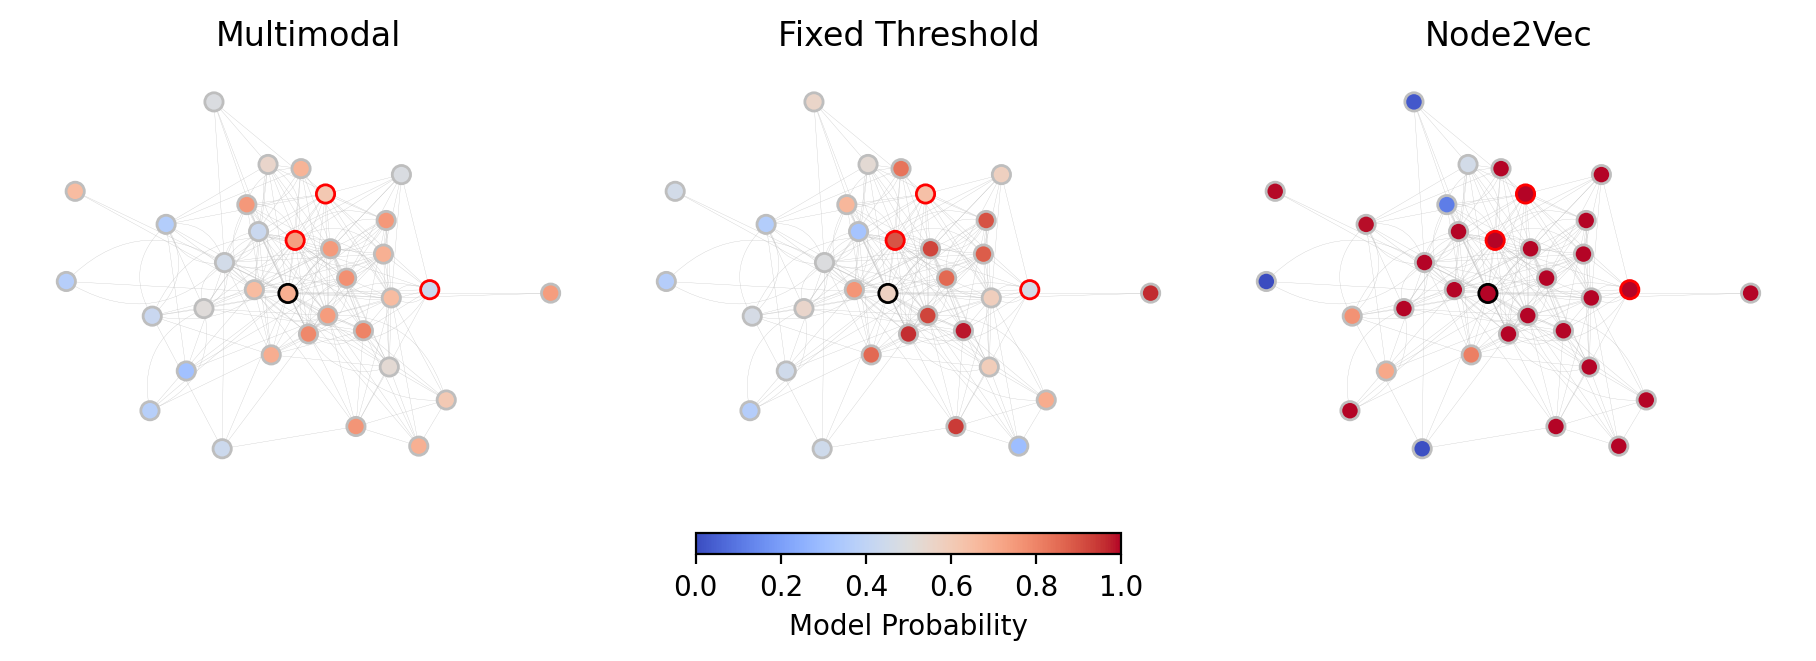

In [1440]:
fig = plot_multiple_igraphs(g, v.index, [multimodal_results_all, fixed_threshold_results_all, n2v_results_df], titles=['Multimodal', 'Fixed Threshold', 'Node2Vec'])

In [1276]:
def plot_kde(g, uid):
    v = g.vs.select(name_eq=str(uid))[0] #(lambda v: v['name']==uid)[0]
    
    user_posts = posts_with_predictions_df.query('`user_id`==@uid').sort_values(by='predictions', ascending=False)
    user_posts.to_csv(os.path.join(experiments_dir, aggregative_methods_dir, 'results', f'echo_2_{uid}_posts.csv'))
    
    followers = g.neighbors(v, mode='in')
    followers_names = g.vs[followers]["name"]
    followees = g.neighbors(v, mode='out')
    followees_names = g.vs[followees]["name"]
    len(followers_names), len(followees_names)

    followees_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followees_names)')
    followers_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followers_names)')
    followees_posts_proba_stats = followees_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
    followers_posts_proba_stats = followers_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
    # followees_posts_proba.groupby('user_id')['predictions'].agg(np.quantile, q=[0.1,0.2])

    sns.kdeplot(x=user_posts['predictions'], common_norm=False, fill=True, label='self')
    sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')
    sns.kdeplot(x=followers_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followers_mean')
    plt.legend()
    # plt.xlim(0, 1)
    plt.title(uid)
    plt.show()

In [ ]:
posts_with_predictions_df

In [ ]:
posts_with_predictions_df.query('`user_id`=="2790069840" and `predictions`<0.5').drop_duplicates(subset=['text']).sort_values('predictions', ascending=False)[:20][['text', 'predictions']].values

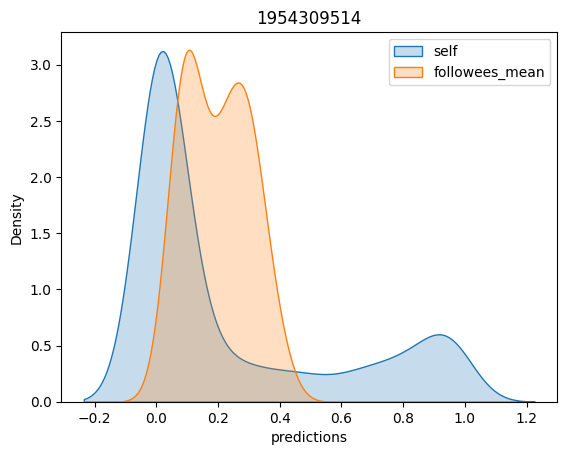

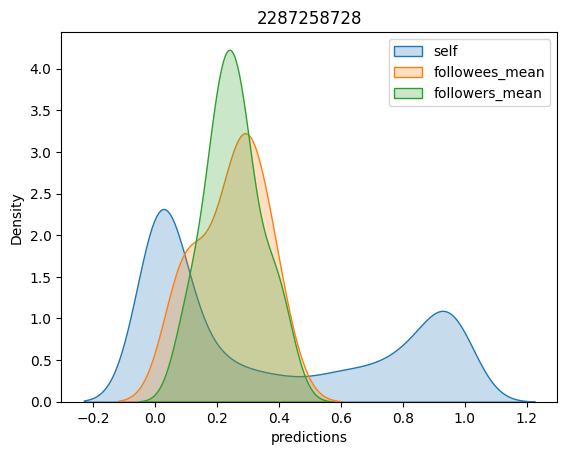

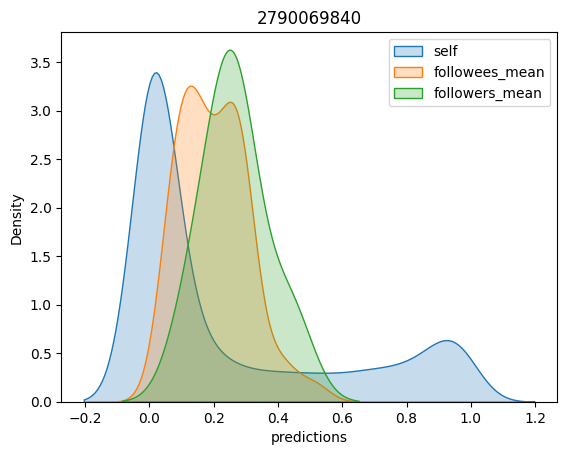

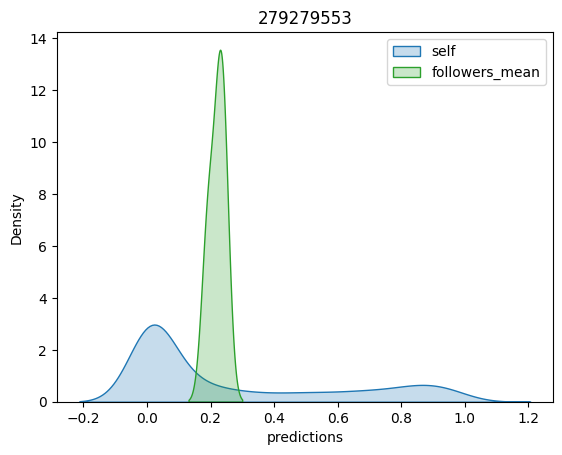

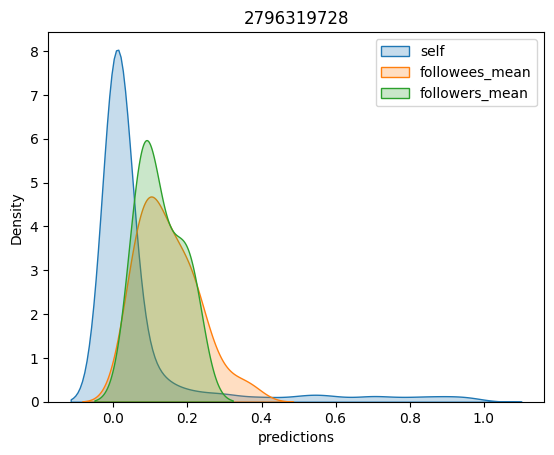

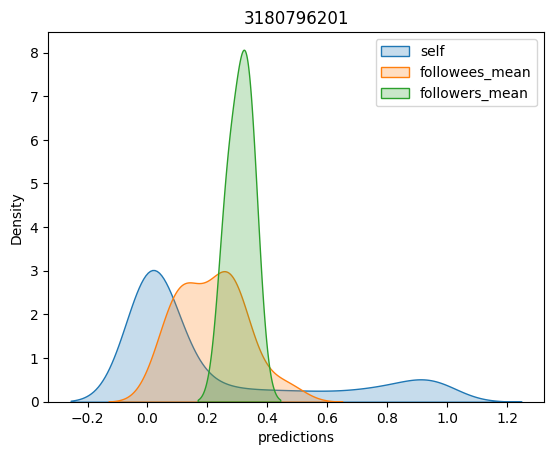

/tmp/ipykernel_232734/4284829326.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followers_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followers_mean')


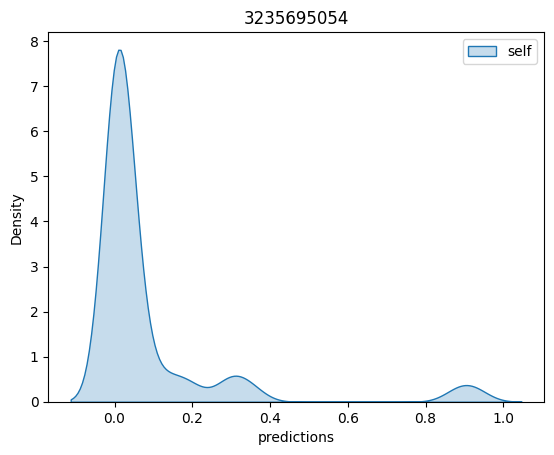

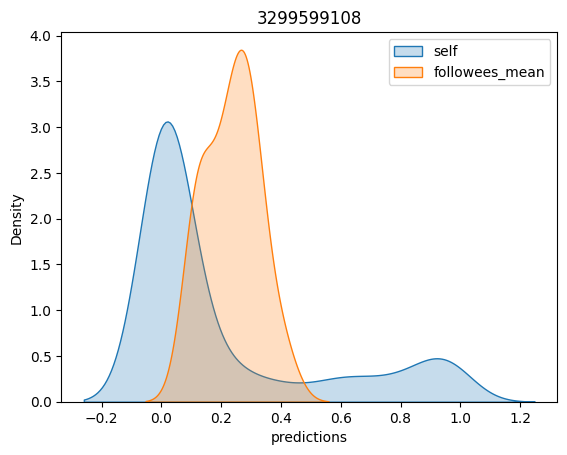

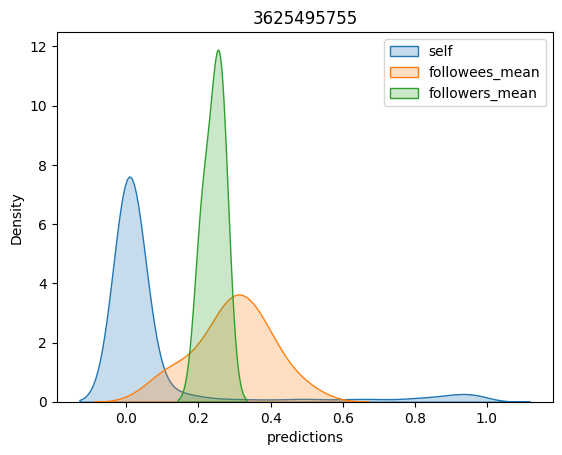

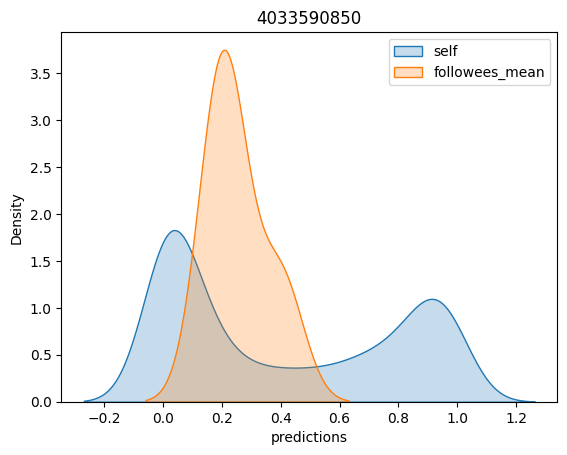

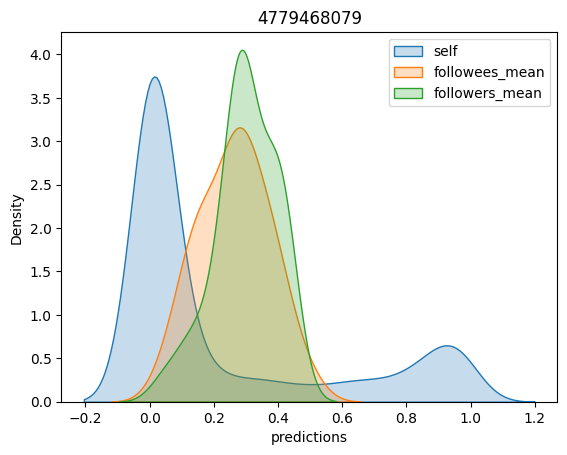

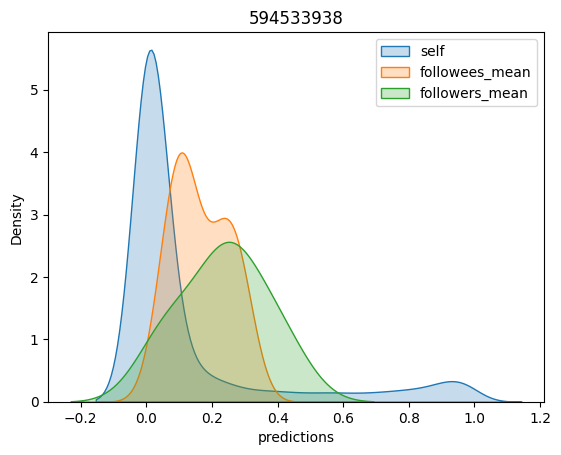

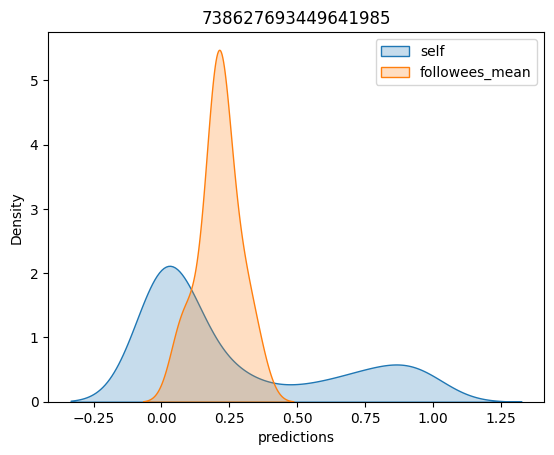

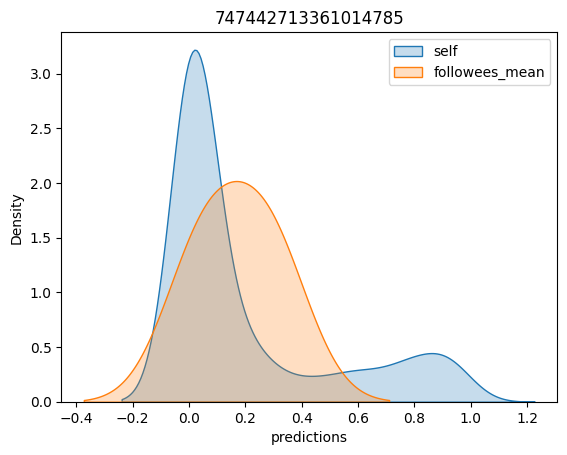

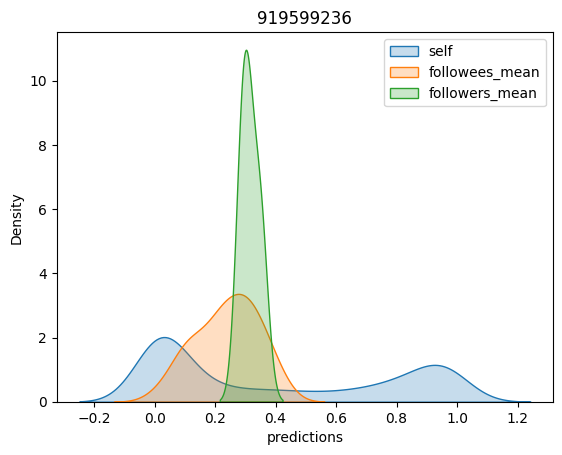

In [656]:
for uid in pos_delta_df.index:
    plot_kde(g, str(uid))

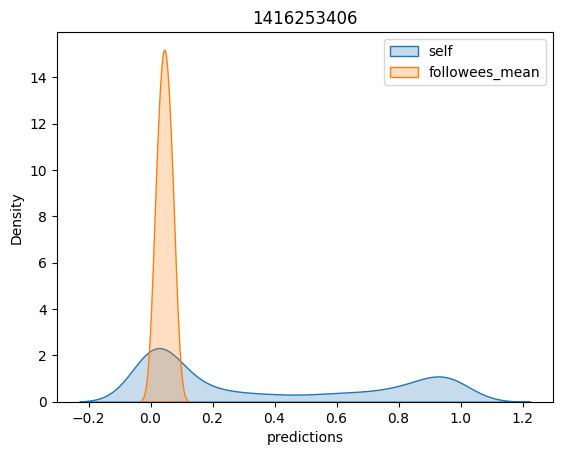

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


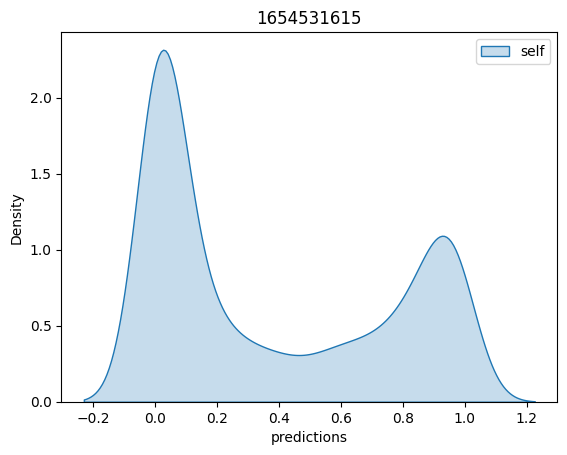

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


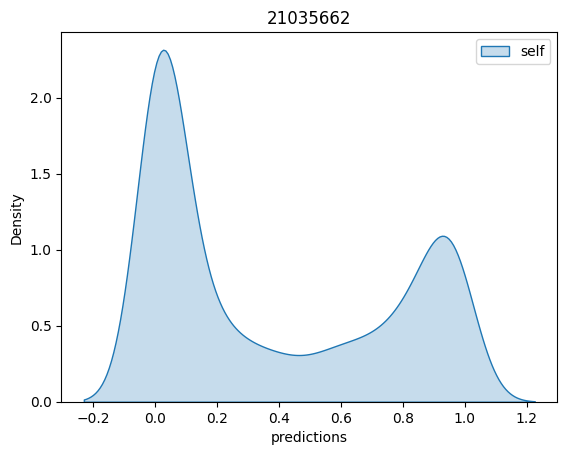

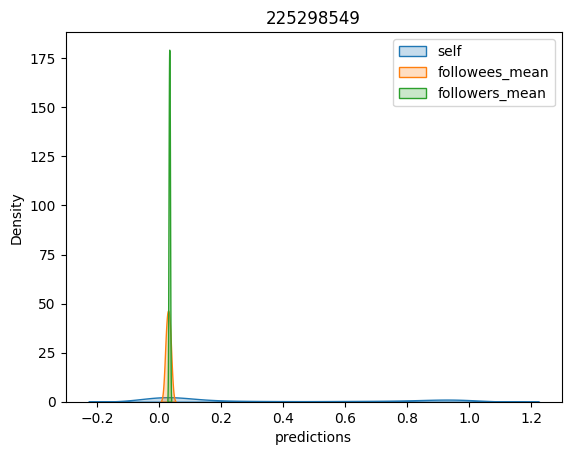

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


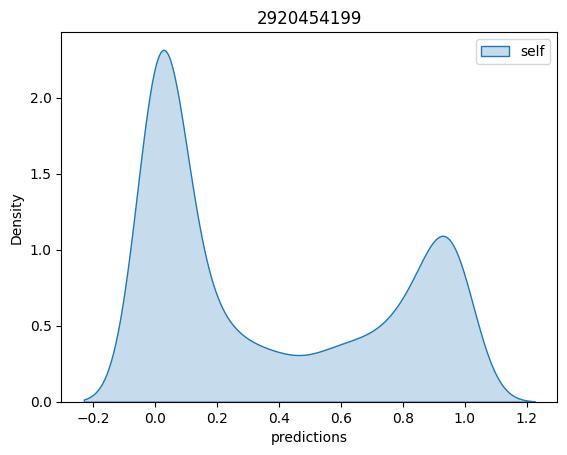

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')
/tmp/ipykernel_232734/1705139308.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followers_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followers_mean')


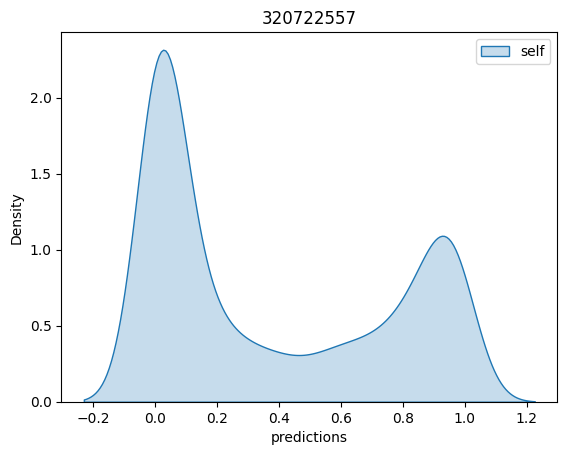

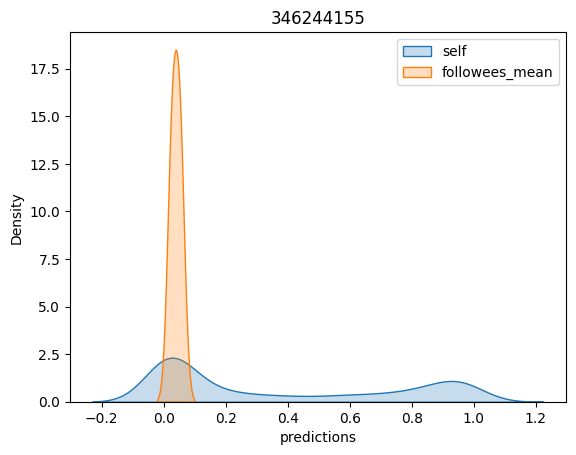

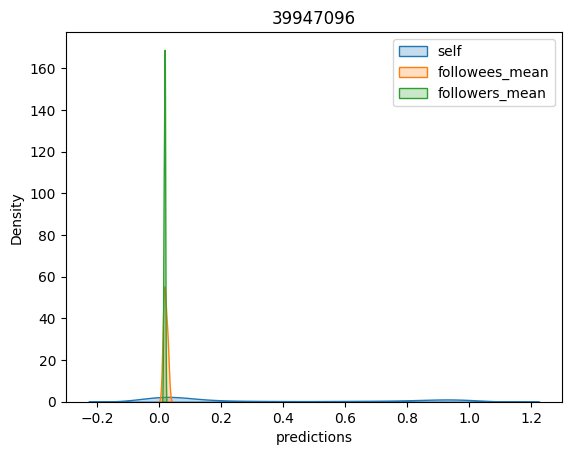

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


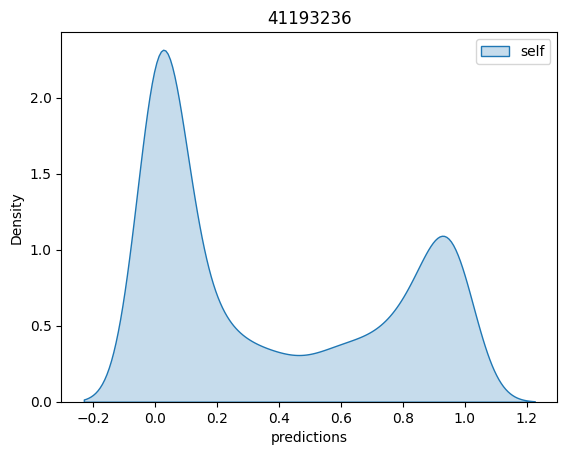

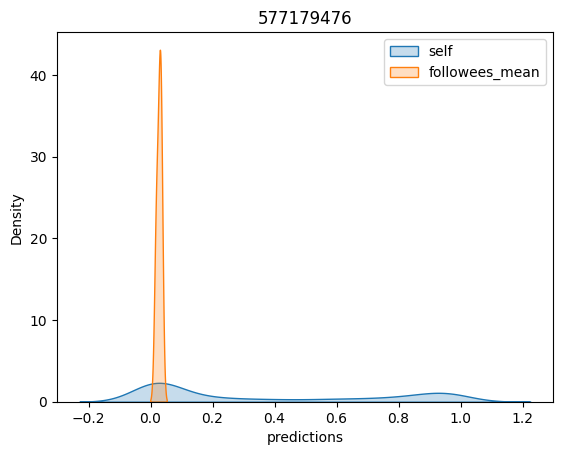

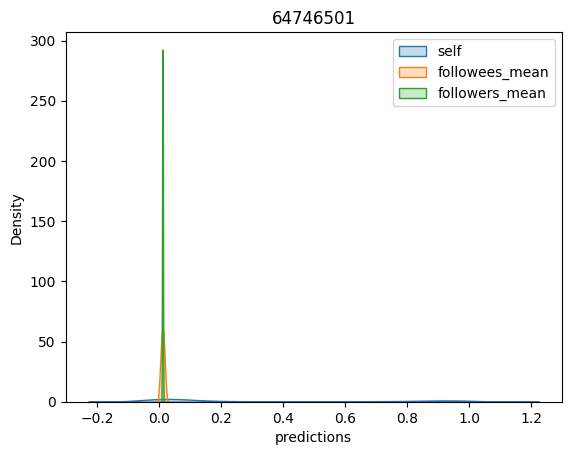

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


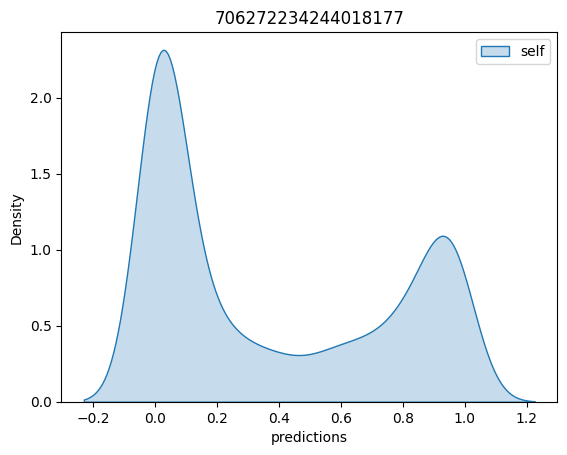

/tmp/ipykernel_232734/1705139308.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')


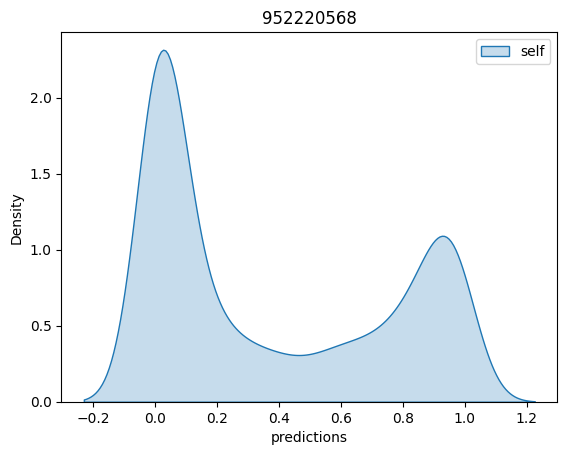

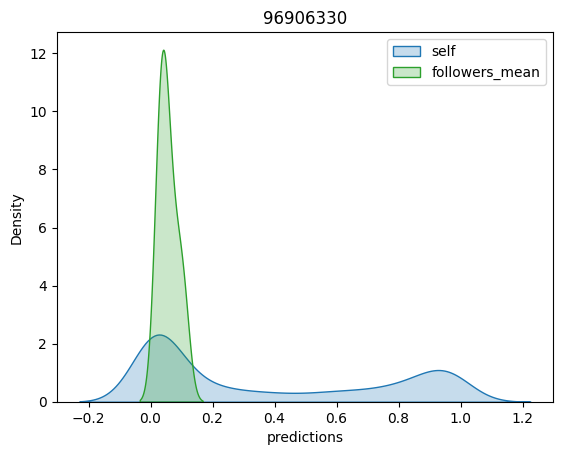

In [654]:
for uid in neg_delta_df.index:
    plot_kde(g, str(uid))

In [669]:
pos_delta_df

,Sample Index,True Labels,Predictions,Probas,Fold
uid,,,,,
1954309514,484,1,1,0.714923,0
2287258728,124,1,1,0.758052,1
2790069840,469,1,1,0.755715,1
279279553,471,1,1,0.763966,1
2796319728,512,1,1,0.698622,1
3180796201,228,1,1,0.833568,2
3235695054,255,1,1,0.704355,2
3299599108,299,1,1,0.717559,2
3625495755,437,1,1,0.622855,2


In [670]:
uid = 594533938

In [673]:
user_posts

,user_id,text,predictions


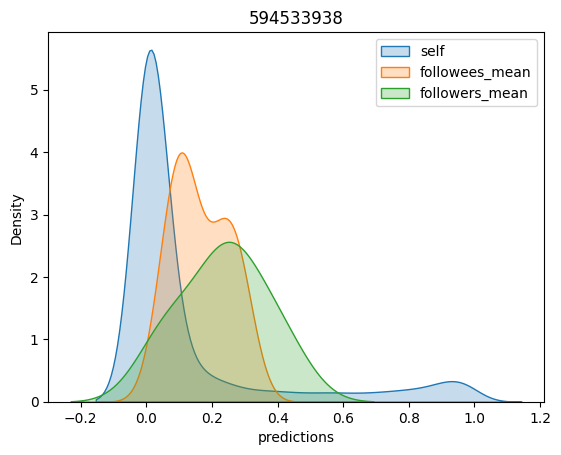

In [675]:
# def plot_kde(g, uid):
uid_s = str(uid)
v = g.vs.select(name_eq=uid_s)[0] #(lambda v: v['name']==uid)[0]

user_posts = posts_with_predictions_df.query('`user_id`==@uid_s').sort_values(by='predictions', ascending=False)
user_posts.to_csv(os.path.join(experiments_dir, aggregative_methods_dir, 'results', f'echo_2_{uid}_posts.csv'))

followers = g.neighbors(v, mode='in')
followers_names = g.vs[followers]["name"]
followees = g.neighbors(v, mode='out')
followees_names = g.vs[followees]["name"]
len(followers_names), len(followees_names)

followees_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followees_names)')
followers_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followers_names)')
followees_posts_proba_stats = followees_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
followers_posts_proba_stats = followers_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
# followees_posts_proba.groupby('user_id')['predictions'].agg(np.quantile, q=[0.1,0.2])

sns.kdeplot(x=user_posts['predictions'], common_norm=False, fill=True, label='self')
sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')
sns.kdeplot(x=followers_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followers_mean')
plt.legend()
# plt.xlim(0, 1)
plt.title(uid)
plt.show()

In [676]:
h

In [678]:
# def plot_kde(g, uid):
uid_s = str(uid)
v = h.vs.select(name_eq=uid_s)[0] #(lambda v: v['name']==uid)[0]

user_posts = posts_with_predictions_df.query('`user_id`==@uid_s').sort_values(by='predictions', ascending=False)
# user_posts.to_csv(os.path.join(experiments_dir, aggregative_methods_dir, 'results', f'echo_2_{uid}_posts.csv'))

followers = h.neighbors(v, mode='in')
followers_names = h.vs[followers]["name"]
followees = h.neighbors(v, mode='out')
followees_names = h.vs[followees]["name"]
len(followers_names), len(followees_names)

(6, 15)

In [683]:
followers

[56, 141, 143, 172, 178, 667]

In [687]:
self_features = v['features']
followers_features = np.array(h.vs[followers]['features'])
followees_features = np.array(h.vs[followees]['features'])
self_features.shape

(20,)

In [696]:
followers_features[:, 1].shape

(6,)

In [ ]:
followees_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followees_names)')
followers_posts_proba = posts_with_predictions_df.query('`user_id`.isin(@followers_names)')
followees_posts_proba_stats = followees_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
followers_posts_proba_stats = followers_posts_proba.groupby('user_id')['predictions'].agg([np.mean, np.median])
# followees_posts_proba.groupby('user_id')['predictions'].agg(np.quantile, q=[0.1,0.2])

sns.kdeplot(x=self_features common_norm=False, fill=True, label='self')
sns.kdeplot(x=followees_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followees_mean')
sns.kdeplot(x=followers_posts_proba_stats['mean'].values, common_norm=False, fill=True, label='followers_mean')
plt.legend()
# plt.xlim(0, 1)
plt.title(uid)
plt.show()

In [443]:
tmp = user_posts.query('`predictions`.between(0,0.5)')
# tmp.head(10)
tmp.shape

(1139, 3)

In [447]:
tmp[tmp['text'].str.contains('.*\(\(\(.*\)\)\).*')]['text'][:20].values

array(['Anti-Russian sentiment is basically an (((elite))) Washington insider consensus. It has no resonance with the people.',
       "Flogging Molly's (((publishers))) already put a copyright claim on my new song. Within 1 hour lmoa",
       'THE DAILY SHOAH will be LIVE ON YOUTUBE WED night at 8PM EST. Call in at (((936))) 666-1488'],
      dtype=object)

In [479]:
models_dict['multimodal_relational_bins_quantiles'] #['fixed_threshold'][:-2].transform(x.loc[[uid]]) #.shape

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=0.026366508987303583,
                                    class_weight='balanced',
                                    random_state=42))])

In [ ]:
multimodal_results_df.loc[int(uid)]

# Plot

In [201]:
import matplotlib.patches as mpatches
import os

# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

In [202]:
df

,Dataset,Method,Accuracy,Precision,Recall,F1,ROC AUC,F1 Mean
0,Echo,DeGroot's Diffusion,0.780 ± 0.055,0.472 ± 0.389,0.255 ± 0.261,0.320 ± 0.310,0.610 ± 0.122,0.320
1,Echo,GCN,0.637 ± 0.171,0.443 ± 0.118,0.914 ± 0.096,0.585 ± 0.104,0.797 ± 0.102,0.585
2,Echo,GraphSAGE,0.831 ± 0.068,0.629 ± 0.124,0.950 ± 0.041,0.752 ± 0.088,0.944 ± 0.024,0.752
3,Echo,GAT,0.757 ± 0.064,0.548 ± 0.131,0.653 ± 0.241,0.574 ± 0.123,0.772 ± 0.091,0.574
4,Echo,AGNN,0.899 ± 0.026,0.759 ± 0.072,0.914 ± 0.054,0.826 ± 0.035,0.963 ± 0.032,0.826
5,Echo,Fixed-Threshold,0.812 ± 0.016,0.654 ± 0.063,0.627 ± 0.095,0.633 ± 0.040,0.836 ± 0.040,0.633
6,Echo,Relational Aggregation,0.908 ± 0.022,0.820 ± 0.060,0.834 ± 0.055,0.825 ± 0.042,0.956 ± 0.013,0.825
7,Echo,Distributional (bins),0.899 ± 0.023,0.772 ± 0.045,0.871 ± 0.058,0.817 ± 0.042,0.944 ± 0.019,0.817
8,Echo,Distributional (quantiles),0.893 ± 0.032,0.747 ± 0.064,0.899 ± 0.047,0.815 ± 0.053,0.942 ± 0.018,0.815
9,Echo,Distributional (bins+quantiles),0.895 ± 0.029,0.757 ± 0.058,0.885 ± 0.052,0.815 ± 0.049,0.946 ± 0.021,0.815


In [ ]:
# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

# Define patterns for each dataset
patterns = {
    'Echo': '///',
    'Gab': 'xxx',
    'Parler': 'ooo'
}

# Create the bar plot
plt.figure(figsize=(15, 8), dpi=300)
ax = sns.barplot(data=df, x='Method', y='F1 Mean', hue='Dataset')

# Apply patterns to bars
for bars, dataset in zip(ax.containers, df['Dataset'].unique()):
    for bar in bars:
        bar.set_hatch(patterns[dataset])

# Add bar labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                fontsize=8,
                textcoords='offset points')

# Customize the plot
# plt.title('F1 Score by Method and Dataset')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()


# Create custom legend
handles = []
colors = sns.color_palette()  # Default color palette

for dataset, color in zip(df['Dataset'].unique(), colors):
    handles.append(mpatches.Patch(facecolor=color, hatch=patterns[dataset], label=dataset))

plt.legend(handles=handles, title='Dataset', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()

In [ ]:
colors

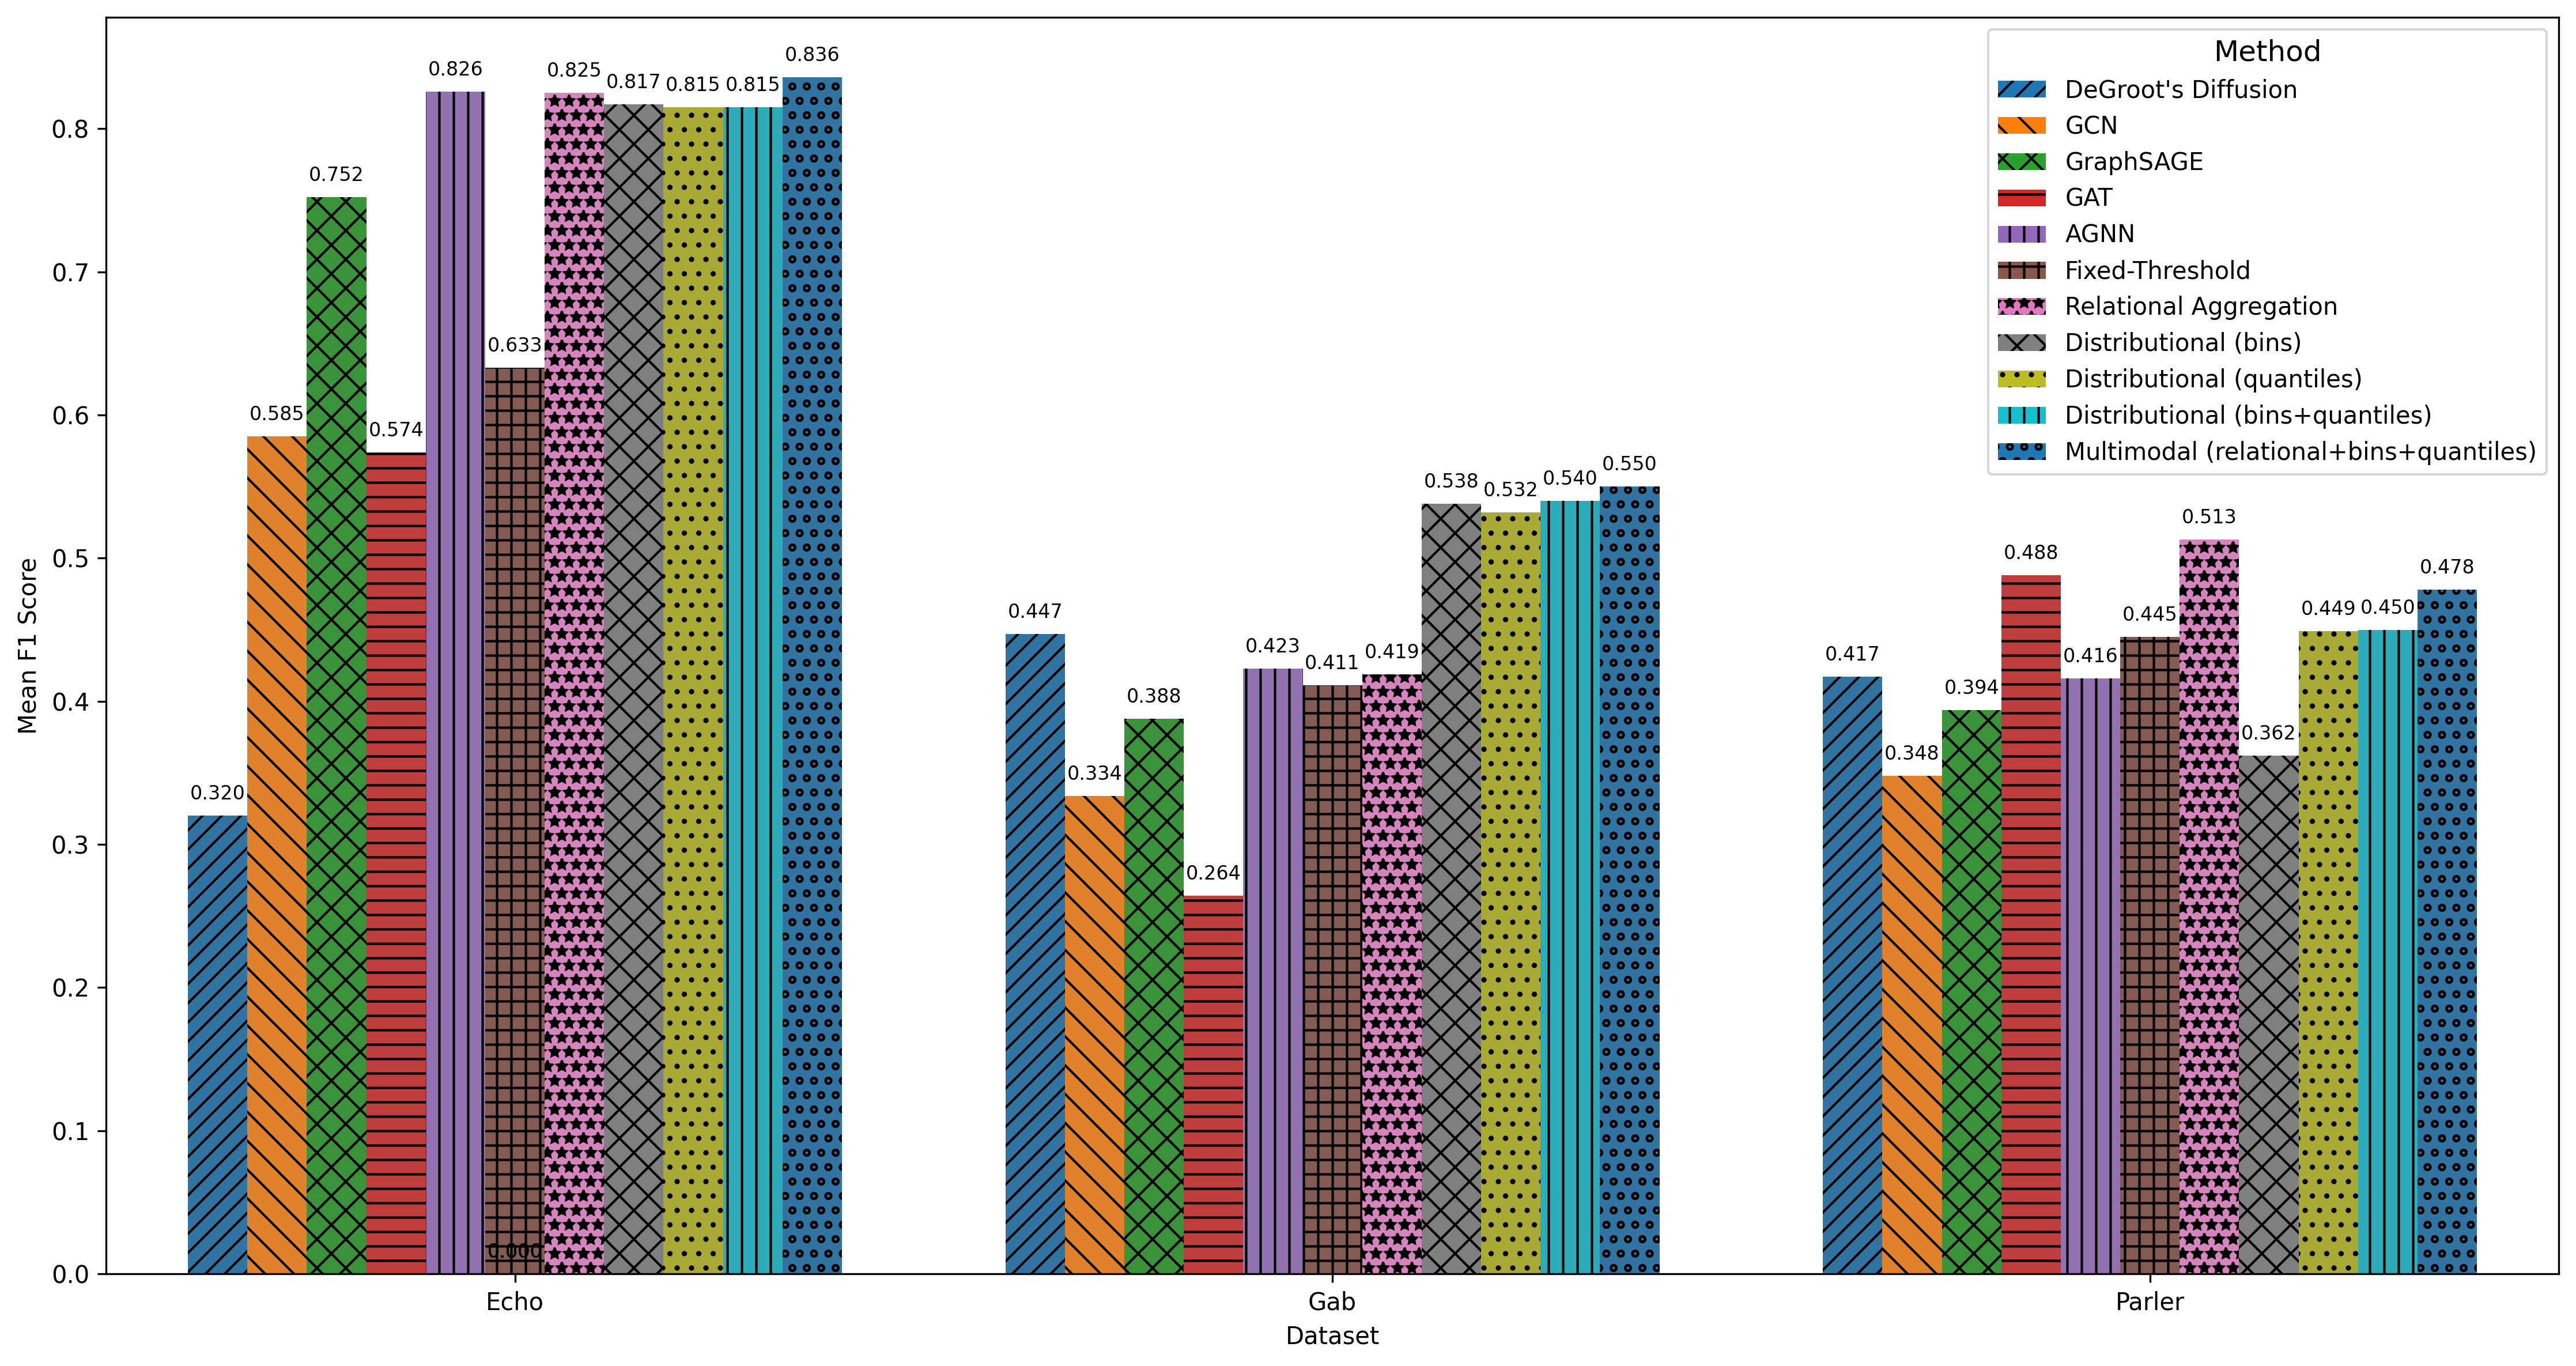

In [208]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

# Define more distinguishable patterns for each method
patterns = {
    "DeGroot's Diffusion": '///',
    'GCN': '\\\\',
    'GraphSAGE': 'xx',
    'GAT': '--',
    'AGNN': '||',
    'Fixed-Threshold': '++',
    'Relational Aggregation': '**',
    'Distributional (bins)': 'xx',
    'Distributional (quantiles)': '..',
    'Distributional (bins+quantiles)': '||',
    'Multimodal (relational+bins+quantiles)': 'oo'
}

# Define the color palette for methods using the 'deep' palette
palette = sns.color_palette('tab10', n_colors=len(df['Method'].unique()))
method_colors = {method: color for method, color in zip(df['Method'].unique(), palette)}

# Create the bar plot
plt.figure(figsize=(15, 8), dpi=300)
ax = sns.barplot(data=df, x='Dataset', y='F1 Mean', hue='Method', palette=method_colors, errorbar=None)

# Apply patterns to bars
for bars, method in zip(ax.containers, df['Method'].unique()):
    for bar in bars:
        bar.set_hatch(patterns[method])

# Add bar labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                fontsize=8,
                textcoords='offset points')

# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Mean F1 Score')
# plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()

# Create custom legend
handles = []

# Ensure legend order matches the order of methods in the data
for method in df['Method'].unique():
    handles.append(mpatches.Patch(facecolor=method_colors[method], hatch=patterns[method], label=method))

plt.legend(handles=handles, title='Method', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()

In [65]:
for dataset in ['echo_2', 'gab', 'parler']:
    df = pd.read_csv(f'~/hate_speech_detection/detection/outputs/{dataset}/BertFineTuning/evaluation/predictions.tsv', sep='\t')
    print(dataset)
    print('binary (only for positive class, what we reported: ', f1_score(df['y_true'], df['y_pred'], average='binary'))
    print('micro: ', f1_score(df['y_true'], df['y_pred'], average='micro'))
    print('macro: ', f1_score(df['y_true'], df['y_pred'], average='macro'))

echo_2
binary (only for positive class, what we reported:  0.5446428571428572
micro:  0.8898488120950323
macro:  0.7409946472446474
gab
binary (only for positive class, what we reported:  0.29896907216494845
micro:  0.864
macro:  0.6118322658720645
parler
binary (only for positive class, what we reported:  0.7126805778491172
micro:  0.7834240774349668
macro:  0.7694470850410635


In [58]:
df = pd.read_csv('~/hate_speech_detection/detection/outputs/echo_2/BertFineTuning/evaluation/predictions.tsv', sep='\t')
print(f1_score(df['y_true'], df['y_pred']))
# print(f1_score(df['y_true'], df['y_pred'], average='average'))
print('micro: ', f1_score(df['y_true'], df['y_pred'], average='micro'))
print('macro: ', f1_score(df['y_true'], df['y_pred'], average='macro'))

0.5446428571428572
micro:  0.8898488120950323
macro:  0.7409946472446474
